In [22]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [ ]:
# Function to extract features from a URL
def extract_features(url):
    features = []
    features.append(len(url))  # URL length
    features.append(url.count('.'))  # Count of '.'
    features.append(url.count('-'))  # Count of '-'
    features.append(url.count('@'))  # Count of '@'
    features.append(url.count('?'))  # Count of '?'
    features.append(url.count('='))  # Count of '='
    features.append(url.count('https'))  # Presence of HTTPS
    features.append(url.count('http'))  # Presence of HTTP
    features.append(url.count('www'))  # Presence of WWW
    features.append(1 if re.search(r'\d+', url) else 0)  # Numeric presence
    return features


In [24]:
# Load dataset (CSV format with 'url' and 'type' columns)
df = pd.read_csv('final_url_dataset.csv')

In [25]:
df.head()

,url,type
0,https://web.archive.org/web/20210308153139/htt...,Benign
1,NaN,benign
2,https://web.archive.org/web/20240121015553/htt...,benign
3,https://tg.wikipedia.org/wiki/%D0%9D%D0%B0%D1%...,benign
4,https://web.archive.org/web/20220329160506/htt...,benign


In [26]:
df.tail()

,url,type
177811,76c4523a0b36bd2b813acc3873765c9bd9d6bbc9,defacement
177812,07e9de645cd50443965e4feb991f79b3ddc9d36e,defacement
177813,dcffb37867094313f043cf754c3e2ce7b0851fdd,defacement
177814,f5572fa071aec4014eebefe1c5df41aad90fec84,defacement
177815,6dec89d45ea68f26c3a8c52b7a42b08e0e9a9035,defacement


In [27]:
df.describe()

,url,type
count,177815,177816
unique,155950,5
top,http://46.19.143.10/bins/zxc.sh,malware
freq,4,152089


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177816 entries, 0 to 177815
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     177815 non-null  object
 1   type    177816 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


In [30]:
# Strip spaces and convert to lowercase to avoid mapping issues
df['type'] = df['type'].str.strip().str.lower()

In [31]:
# Define mapping dictionary
label_mapping = {'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3}

# Replace values with numeric labels
df['type'] = df['type'].map(label_mapping)

In [32]:
# Check if there are still NaN values
print("Missing Values Count:", df['type'].isna().sum())

Missing Values Count: 0


In [33]:
df.head()

,url,type
0,https://web.archive.org/web/20210308153139/htt...,0
1,NaN,0
2,https://web.archive.org/web/20240121015553/htt...,0
3,https://tg.wikipedia.org/wiki/%D0%9D%D0%B0%D1%...,0
4,https://web.archive.org/web/20220329160506/htt...,0


In [34]:
# Count each category
category_counts = df['type'].value_counts()
print("Original Data Distribution:\n", category_counts)

Original Data Distribution:
 type
3    152089
2      9434
1      8883
0      7410
Name: count, dtype: int64


In [35]:
# Balance the dataset by undersampling (equal rows for each category)
min_count = category_counts.min()  # Get minimum count among categories
balanced_df = df.groupby('type').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)

C:\Users\HRUSHI\AppData\Local\Temp\ipykernel_5328\4058552278.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('type').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)


In [36]:
# Show new category distribution
print("\nBalanced Data Distribution:\n", balanced_df['type'].value_counts())


Balanced Data Distribution:
 type
0    7410
1    7410
2    7410
3    7410
Name: count, dtype: int64


In [37]:
# Extract features

balanced_df['features'] = balanced_df['url'].apply(lambda x: extract_features(x))
X = np.array(balanced_df['features'].tolist())
y = balanced_df['type'].values  # Labels: 0 = benign, 1 = defacement, 2 = phishing, 3 = malware

TypeError: object of type 'float' has no len()

In [ ]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Evaluate model0
# Evaluate model
y_pred = clf.predict(X_test)  # Fix misplaced text
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))  # Fix truncated variable name


Model Accuracy: 55.26%
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91      1482
           1       0.37      0.41      0.39      1482
           2       0.33      0.20      0.25      1482
           3       0.54      0.67      0.60      1482

    accuracy                           0.55      5928
   macro avg       0.53      0.55      0.54      5928
weighted avg       0.53      0.55      0.54      5928



In [ ]:
# Save the model
joblib.dump(clf, 'malicious_url_model.pkl')

['malicious_url_model.pkl']

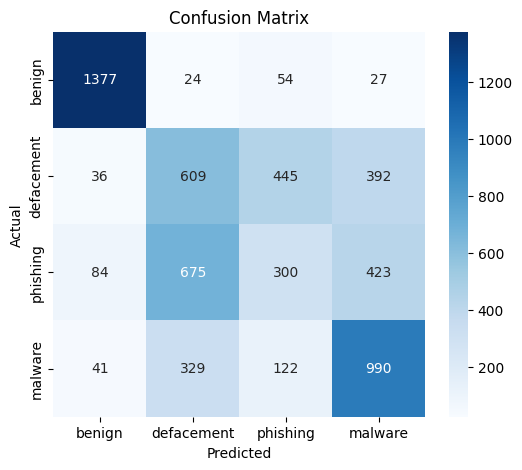

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Function to predict if a URL is malicious
def predict_url(url):
    clf = joblib.load('malicious_url_model.pkl')  # Load trained model
    features = np.array(extract_features(url)).reshape(1, -1)
    prediction = clf.predict(features)[0]

    # Map prediction back to category name
    reverse_mapping = {0: 'benign', 1: 'defacement', 2: 'phishing', 3: 'malware'}
    return reverse_mapping[prediction]

In [ ]:
# Example usage
test_url = "https://web.whatsapp.com/"
print(f"URL: {test_url} is classified as {predict_url(test_url)}")

URL: https://web.whatsapp.com/ is classified as phishing


Missing Values Count: 0
Original Data Distribution:
 type
3    152089
2      9434
1      8883
0      7409
Name: count, dtype: int64

Balanced Data Distribution:
 type
0    7409
1    7409
2    7409
3    7409
Name: count, dtype: int64


C:\Users\HRUSHI\AppData\Local\Temp\ipykernel_17344\3795741069.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('type').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)


Model Accuracy: 55.08%
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91      1482
           1       0.37      0.41      0.39      1482
           2       0.33      0.20      0.25      1482
           3       0.54      0.67      0.59      1482

    accuracy                           0.55      5928
   macro avg       0.53      0.55      0.54      5928
weighted avg       0.53      0.55      0.54      5928



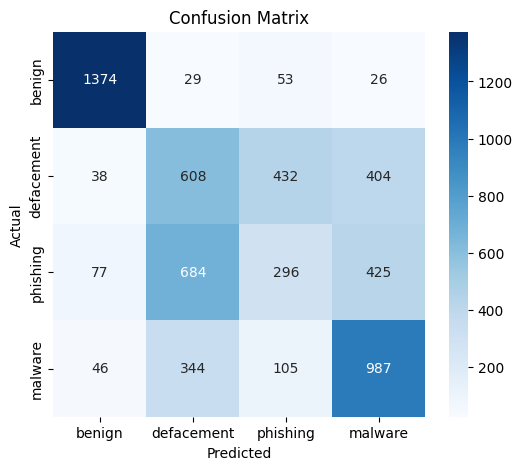

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Function to extract features from a URL
def extract_features(url):
    features = []
    features.append(len(url))  # URL length
    features.append(url.count('.'))  # Count of '.'
    features.append(url.count('-'))  # Count of '-'
    features.append(url.count('@'))  # Count of '@'
    features.append(url.count('?'))  # Count of '?'
    features.append(url.count('='))  # Count of '='
    features.append(url.count('https'))  # Presence of HTTPS
    features.append(url.count('http'))  # Presence of HTTP
    features.append(url.count('www'))  # Presence of WWW
    features.append(1 if re.search(r'\d+', url) else 0)  # Numeric presence
    return features

# Load dataset (CSV format with 'url' and 'type' columns)
df = pd.read_csv('final_url_dataset.csv')

# Remove rows with missing values
df.dropna(inplace=True)

# Strip spaces and convert to lowercase to avoid mapping issues
df['type'] = df['type'].str.strip().str.lower()

# Define mapping dictionary
label_mapping = {'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3}

# Replace values with numeric labels
df['type'] = df['type'].map(label_mapping)

# Check if there are still NaN values
print("Missing Values Count:", df['type'].isna().sum())

# Remove any remaining NaN values after mapping
df.dropna(inplace=True)

# Count each category
category_counts = df['type'].value_counts()
print("Original Data Distribution:\n", category_counts)

# Balance the dataset by undersampling (equal rows for each category)
min_count = category_counts.min()  # Get minimum count among categories
balanced_df = df.groupby('type').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)

# Show new category distribution
print("\nBalanced Data Distribution:\n", balanced_df['type'].value_counts())

# Extract features
balanced_df['features'] = balanced_df['url'].apply(lambda x: extract_features(x))
X = np.array(balanced_df['features'].tolist())
y = balanced_df['type'].values  # Labels: 0 = benign, 1 = defacement, 2 = phishing, 3 = malware

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))
# Save the model
joblib.dump(clf, 'malicious_url_model.pkl')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [ ]:
import joblib
import numpy as np
import pandas as pd

def encode_url(url):
    """Convert a URL into ASCII Hex Encoding (UTF-8 Safe)."""
    return url.encode('utf-8').hex()

def predict_url(url):
    """Predict if a URL is malicious while keeping encoding for lookup only."""
    clf = joblib.load('malicious_url_model.pkl')  # Load trained model

    # Extract features from the raw URL (not encoded)
    features = np.array(extract_features(url)).reshape(1, -1)

    # Make prediction
    prediction = clf.predict(features)[0]

    # Map prediction back to category name
    reverse_mapping = {0: 'benign', 1: 'defacement', 2: 'phishing', 3: 'malware'}
    
    return reverse_mapping[prediction]

# Example usage
test_url = "steamglfts.h16.ru"
print(f"URL: {test_url} is classified as {predict_url(test_url)}")


URL: steamglfts.h16.ru is classified as defacement


In [ ]:
from fpdf import FPDF
import joblib
import re
import socket
import whois
import pandas as pd

INFO:numexpr.utils:NumExpr defaulting to 12 threads.


In [ ]:


def extract_features(url):
    features = [
        len(url),  # URL length
        url.count('.'),
        url.count('-'),
        url.count('@'),
        url.count('?'),
        url.count('='),
        url.count('https'),
        url.count('http'),
        url.count('www'),
        1 if re.search(r'\d+', url) else 0  # Numeric presence
    ]
    return features

def get_domain_info(url):
    try:
        domain = re.sub(r'^https?://', '', url).split('/')[0]
        ip = socket.gethostbyname(domain)
        whois_info = whois.whois(domain)
        return domain, ip, whois_info.creation_date
    except Exception:
        return None, None, None

def generate_pdf_report(url, prediction, feature_importance, output_file):
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()
    pdf.set_font("Arial", 'B', 16)
    pdf.cell(200, 10, "Malicious URL Report", ln=True, align='C')
    pdf.ln(10)
    
    pdf.set_font("Arial", size=12)
    pdf.cell(0, 10, f"URL: {url}", ln=True)
    pdf.cell(0, 10, f"Prediction: {prediction}", ln=True)
    pdf.ln(5)
    
    pdf.set_font("Arial", 'B', 12)
    pdf.cell(0, 10, "Feature Contributions:", ln=True)
    pdf.set_font("Arial", size=12)
    for feature, value in feature_importance.items():
        pdf.cell(0, 10, f"- {feature}: {value}", ln=True)
    pdf.ln(5)
    
    pdf.set_font("Arial", 'B', 12)
    pdf.cell(0, 10, "Security Insights:", ln=True)
    pdf.set_font("Arial", size=12)
    security_threats = {
        "Benign": "No threats detected.",
        "Defacement": "Website might be compromised or defaced.",
        "Phishing": "URL may attempt to steal credentials.",
        "Malware": "URL distributes malware or viruses."
    }
    pdf.multi_cell(0, 10, security_threats.get(prediction, "Unknown threat."))
    pdf.ln(5)
    
    domain, ip, creation_date = get_domain_info(url)
    if domain:
        pdf.set_font("Arial", 'B', 12)
        pdf.cell(0, 10, "WHOIS & IP Details:", ln=True)
        pdf.set_font("Arial", size=12)
        pdf.cell(0, 10, f"Domain: {domain}", ln=True)
        pdf.cell(0, 10, f"IP Address: {ip}", ln=True)
        pdf.cell(0, 10, f"Creation Date: {creation_date}", ln=True)
        pdf.ln(5)
    
    pdf.output(output_file)
    print(f"Report saved: {output_file}")

# Load the trained model
clf = joblib.load('malicious_url_model.pkl')
label_mapping = {0: 'Benign', 1: 'Defacement', 2: 'Phishing', 3: 'Malware'}
feature_names = ['URL Length', 'Dot Count', 'Dash Count', 'At Symbol', 'Question Mark', 'Equals Sign', 'HTTPS Presence', 'HTTP Presence', 'WWW Presence', 'Numeric Presence']

# Example usage
url_to_check = "https://chatgpt.com/c/67c7e26a-8bb0-8010-b20c-001eee124de4"
features = extract_features(url_to_check)
predicted_class = clf.predict([features])[0]
prediction_label = label_mapping[predicted_class]

feature_importance = {feature_names[i]: features[i] for i in range(len(feature_names))}

generate_pdf_report(url_to_check, prediction_label, feature_importance, "malicious_url_report.pdf")


c:\Users\Shailesh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Shailesh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Report saved: malicious_url_report.pdf


In [ ]:
from fpdf import FPDF
import joblib
import re
import socket
import whois
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


safety_thresholds = {
    'Dot Count': (3, 7),
    'Dash Count': (0, 2),
    'At Symbol': (0, 0),
    'Question Mark': (0, 2),
    'Equals Sign': (0, 3),
    'HTTPS Presence': (1, 1),
    'HTTP Presence': (0, 0),
    'WWW Presence': (0, 1),
    'Numeric Presence': (0, 1),
    'Digit Count': (0, 10),
    'Alphabet Count': (10, 100),
    'Slash Count': (1, 5),
    'Percent Count': (0, 2),
    'Ampersand Count': (0, 2),
    'Semicolon Count': (0, 1),
    'Underscore Count': (0, 3),
    'Colon Count': (0, 2),
    'Exclamation Mark': (0, 1),
    'Asterisk': (0, 1),
    'Comma': (0, 2),
    'Dollar Sign': (0, 1),
    'Tilde': (0, 1)
}


# Function to extract features from a URL
def extract_features(url):
    features = [
        len(url),  # URL length
        url.count('.'),
        url.count('-'),
        url.count('@'),
        url.count('?'),
        url.count('='),
        url.count('https'),
        url.count('http'),
        url.count('www'),
        1 if re.search(r'\d+', url) else 0,  # Numeric presence
        sum(c.isdigit() for c in url),  # Count of digits
        sum(c.isalpha() for c in url),  # Count of alphabets
        url.count('/'),  # Count of '/'
        url.count('%'),  # Count of '%'
        url.count('&'),  # Count of '&'
        url.count(';'),  # Count of ';'
        url.count('_'),  # Count of '_'
        url.count(':'),  # Count of ':'
        url.count('!'),  # Count of '!'
        url.count('*'),  # Count of '*'
        url.count(','),  # Count of ','
        url.count('$'),  # Count of '$'
        url.count('~')   # Count of '~'
    ]
    return features

# Function to analyze feature safety
def analyze_feature_safety(features):
    safety_analysis = {}
    feature_names = list(safety_thresholds.keys())
    
    for i, feature in enumerate(feature_names):
        min_val, max_val = safety_thresholds[feature]
        status = "Safe" if min_val <= features[i] <= max_val else "Harmful"
        safety_analysis[feature] = {"count": features[i], "status": status}
    
    return safety_analysis

# Load dataset
df = pd.read_csv('final_url_dataset.csv')
df.dropna(inplace=True)
df['type'] = df['type'].str.strip().str.lower()
label_mapping = {'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3}
df['type'] = df['type'].map(label_mapping)
df.dropna(inplace=True)

# Extract features
df['features'] = df['url'].apply(lambda x: extract_features(x))
X = np.array(df['features'].tolist())
y = df['type'].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42)
}

trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print(classification_report(y_test, y_pred))
    trained_models[name] = model
    joblib.dump(model, f"{name.replace(' ', '_').lower()}_model.pkl")

# Load the trained model
clf = joblib.load('random_forest_model.pkl')  # Default model
label_mapping = {0: 'Benign', 1: 'Defacement', 2: 'Phishing', 3: 'Malware'}
feature_names = list(safety_thresholds.keys())

# Example usage
url_to_check = "https://chatgpt.com/c/67c7e26a-8bb0-8010-b20c-001eee124de4"
features = extract_features(url_to_check)
predicted_class = clf.predict([features])[0]
prediction_label = label_mapping[predicted_class]
feature_safety = analyze_feature_safety(features)

def generate_pdf_report(url, prediction, feature_safety, output_file):
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()
    pdf.set_font("Arial", 'B', 16)
    pdf.cell(200, 10, "Malicious URL Report", ln=True, align='C')
    pdf.ln(10)
    
    pdf.set_font("Arial", size=12)
    pdf.cell(0, 10, f"URL: {url}", ln=True)
    pdf.cell(0, 10, f"Prediction: {prediction}", ln=True)
    pdf.ln(5)
    
    pdf.set_font("Arial", 'B', 12)
    pdf.cell(0, 10, "Feature Safety Analysis:", ln=True)
    pdf.set_font("Arial", size=12)
    
    for feature, details in feature_safety.items():
        pdf.cell(0, 10, f"- {feature}: {details['count']} ({details['status']})", ln=True)
    
    pdf.ln(5)
    pdf.output(output_file)
    print(f"Report saved: {output_file}")


generate_pdf_report(url_to_check, prediction_label, feature_safety, "malicious_url_report.pdf")

Random Forest Accuracy: 88.32%
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1482
           1       0.17      0.05      0.08      1777
           2       0.17      0.05      0.08      1887
           3       0.90      0.98      0.94     30418

    accuracy                           0.88     35564
   macro avg       0.55      0.51      0.51     35564
weighted avg       0.83      0.88      0.85     35564

Naive Bayes Accuracy: 85.80%
              precision    recall  f1-score   support

           0       0.56      0.59      0.57      1482
           1       0.28      0.22      0.24      1777
           2       0.32      0.00      0.01      1887
           3       0.90      0.96      0.93     30418

    accuracy                           0.86     35564
   macro avg       0.51      0.44      0.44     35564
weighted avg       0.82      0.86      0.83     35564

AdaBoost Accuracy: 87.93%
              precision    recall  f1-score 